<a href="https://colab.research.google.com/github/SloppyCalculator/Football-Injury-Prediction/blob/main/Hashan%20/Model/InjuryPrediction%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('walk_data_meta.csv')
df.head()

,sub_id,datestring,filename,speed_w,age,Height,Weight,Gender,DominantLeg,InjDefn,...,SpecInjury2,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces
0,100433,2010-10-05 13:22,20101005T132240.json,1.113930,53,NaN,NaN,Unknown,NaN,Training volume/intensity affected,...,NaN,"walking, horseback riding, strength training",Recreational,13.0,10k,NaN,NaN,NaN,NaN,NaN
1,100434,2010-11-17 13:22,20101117T132240.json,1.107742,51,NaN,NaN,Female,NaN,Training volume/intensity affected,...,NaN,"running, swimming",Recreational,20.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
2,100537,2012-07-03 10:25,20120703T102550.json,1.121041,255,173.1,67.6,Female,Right,2 workouts missed in a row,...,NaN,"hiking, power walking, pilates",Recreational,2.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
3,100560,2012-07-17 10:37,20120717T103748.json,1.322763,33,179.3,83.0,Female,Right,No injury,...,NaN,Yoga,Recreational,NaN,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
4,101481,2012-07-17 10:50,20120717T105021.json,1.120394,32,176.3,58.6,Female,NaN,No injury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['can_play_next_match'] = df['InjDefn'].fillna('No injury').apply(lambda x: 1 if "no injury" in x.lower() else 0)

print("Target value counts:")
print(df['can_play_next_match'].value_counts())


Target value counts:
can_play_next_match
0    1092
1     996
Name: count, dtype: int64


In [5]:
cols_to_drop = [
    'sub_id', 'datestring', 'filename', 'InjDefn', 'InjJoint', 'InjSide', 'SpecInjury',
    'InjDuration', 'InjJoint2', 'InjSide2', 'SpecInjury2', 'Activities',
    'RaceDistance', 'RaceTimeHrs', 'RaceTimeMins', 'RaceTimeSecs', 'YrPR', 'NumRaces'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

df.drop_duplicates(inplace=True)

print("Data shape after dropping unwanted columns and duplicates:", df.shape)
df.head()

Data shape after dropping unwanted columns and duplicates: (2088, 9)


,speed_w,age,Height,Weight,Gender,DominantLeg,Level,YrsRunning,can_play_next_match
0,1.113930,53,NaN,NaN,Unknown,NaN,Recreational,13.0,0
1,1.107742,51,NaN,NaN,Female,NaN,Recreational,20.0,0
2,1.121041,255,173.1,67.6,Female,Right,Recreational,2.0,0
3,1.322763,33,179.3,83.0,Female,Right,Recreational,NaN,1
4,1.120394,32,176.3,58.6,Female,NaN,NaN,NaN,1


In [6]:
numeric_cols = ['speed_w', 'age', 'Height', 'Weight', 'YrsRunning']
categorical_cols = ['Gender', 'DominantLeg', 'Level']

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values per column after imputation:")
print(df.isnull().sum())

Missing values per column after imputation:
speed_w                0
age                    0
Height                 0
Weight                 0
Gender                 0
DominantLeg            0
Level                  0
YrsRunning             0
can_play_next_match    0
dtype: int64


In [7]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for col in numeric_cols:
    if col in df.columns:
        df = remove_outliers(df, col)

print("Data shape after outlier removal:", df.shape)



Data shape after outlier removal: (1534, 9)


In [8]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,speed_w,age,Height,Weight,YrsRunning,can_play_next_match,Gender_Male,Gender_Unknown,DominantLeg_Left,DominantLeg_Right,Level_Recreational
0,1.113930,53,171.0,70.0,13.0,0,False,True,False,True,True
3,1.322763,33,179.3,83.0,8.0,1,False,False,False,True,True
4,1.120394,32,176.3,58.6,8.0,1,False,False,False,True,True
5,1.119657,51,173.0,67.3,1.0,0,True,False,False,True,True
7,1.119169,33,181.4,90.5,7.0,0,True,False,True,False,True


In [9]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

,speed_w,age,Height,Weight,YrsRunning,can_play_next_match,Gender_Male,Gender_Unknown,DominantLeg_Left,DominantLeg_Right,Level_Recreational
0,-0.741970,0.757860,-0.015094,-0.110941,1.795392,0,False,True,False,True,True
3,1.574096,-0.696973,0.907279,0.875030,0.288220,1,False,False,False,True,True
4,-0.670281,-0.769715,0.573891,-0.975562,0.288220,1,False,False,False,True,True
5,-0.678460,0.612376,0.207164,-0.315720,-1.821821,0,True,False,False,True,True
7,-0.683869,-0.696973,1.140651,1.443860,-0.013215,0,True,False,True,False,True


In [10]:
X = df.drop('can_play_next_match', axis=1)
y = df['can_play_next_match']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1227, 10)
Test set shape: (307, 10)


In [11]:
print("Original training target distribution:")
print(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nAfter applying SMOTE, training target distribution:")
print(pd.Series(y_train_res).value_counts())

Original training target distribution:
can_play_next_match
0    617
1    610
Name: count, dtype: int64

After applying SMOTE, training target distribution:
can_play_next_match
1    617
0    617
Name: count, dtype: int64


In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [14]:
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[116  38]
 [ 47 106]]
Confusion Matrix:
[[116  38]
 [ 47 106]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       154
           1       0.74      0.69      0.71       153

    accuracy                           0.72       307
   macro avg       0.72      0.72      0.72       307
weighted avg       0.72      0.72      0.72       307

Accuracy: 0.7231270358306189


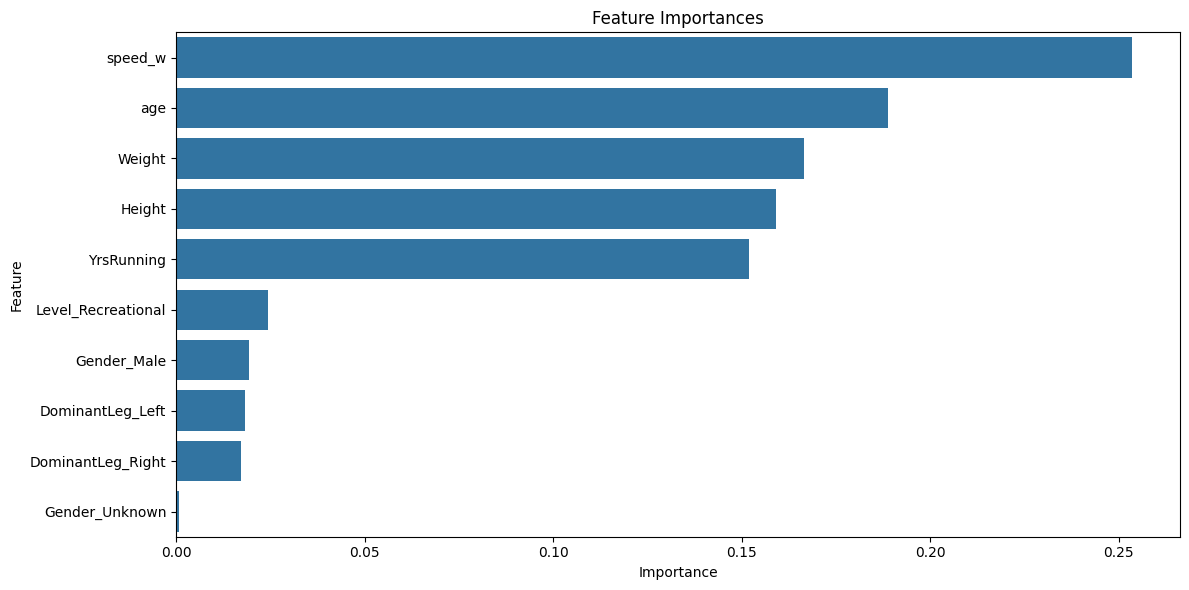

In [15]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()